# Анализ данных поездок и погоды (Первичный анализ)

В этой тетрадке выполняется первичный осмотр данных поездок и погодных условий, выявляются пропуски, дубликаты и аномалии. Данные еще не очищены и не нормализованы — это подготовительный этап перед дальнейшей обработкой и визуализацией.

## 1. Импорт библиотек

Импортируем стандартные библиотеки для анализа данных, а также пользовательские функции для визуализации и первичного осмотра данных.

In [1]:
import os

import pandas as pd

from utils.vizualization import plot_hist_boxplot, plot_scatterplot
from utils.overview import get_missed_info, get_duplicated_info, describe_categorical, print_consecutive_nans

## 2. Установка рабочей директории

Определяем корневую директорию проекта для корректного чтения файлов.

In [2]:
HOME = os.getcwd().removesuffix("/notebooks")

## 3. Загрузка данных

Загружаем файлы rides.csv и weather.csv.
Если стандартный разделитель и кодировка не подходят, пробуем альтернативный вариант (;).

In [3]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": f"{HOME}/data/rides.csv",
    "encoding": "utf-8",
    "parse_dates": ["Start Date", "End Date"],
}

weather_options = {
    "filepath_or_buffer": f"{HOME}/data/weather.csv",
    "encoding": "utf-8",
    "parse_dates": ["Datetime"]
}

try:
    rides_data = pd.read_csv(**rides_options)
    weather_data = pd.read_csv(**weather_options)
except pd.errors.ParserError as e:
    print(f"Error: {e}")
    rides_data = pd.read_csv(**rides_options, sep=";")
    weather_data = pd.read_csv(**weather_options, sep=";")

# 4. Переименование колонок

In [4]:
rides_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

weather_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

## 5. Первичный осмотр данных о поездках

Проводим базовый анализ структуры данных: просмотр выборки, типов колонок, пропусков и дубликатов.

### 5.1. Случайные строки и общая информация

In [5]:
rides_data.sample(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
60862,158280,2023-06-24 08:22:56,2023-06-24 08:41:38,Победы,юго-восточный,Комсомольская,заречный,3504.0,0
96413,192146,2023-07-26 21:16:06,2023-07-26 21:33:32,Степная,Центральный,Шевченко,юго-восточный,2714.0,0
20998,120343,2023-05-15 14:56:51,2023-05-15 15:31:45,ул. красная,Северо-Западный,ул.заречная,Юго-Восточный,4560.0,0
31680,130514,2023-05-27 13:40:09,2023-05-27 14:35:43,Некрасова,северо-западный,Центральная,Юго-Восточный,7225.0,0
17789,117286,2023-05-12 10:47:11,2023-05-12 11:15:40,ул.космонавтов,Юго-Восточный,ул.шоссейная,Заречный,5085.0,0
20243,119615,2023-05-14 18:05:41,2023-05-14 18:29:28,ул. спортивная,Октябрьский,ул.горького,юго-восточный,3300.0,0
98829,194444,2023-07-29 10:19:21,2023-07-29 10:49:55,ул. березовая,Северо-Западный,ул.майская,Октябрьский,3998.0,0
99991,195554,2023-07-30 10:30:45,2023-07-30 11:27:09,Юбилейная,Юго-Восточный,Новая,северо-западный,6590.0,0
15425,115035,2023-05-09 08:22:39,2023-05-09 08:59:51,Матросова,центральный,Комарова,ленинский,4420.0,0
56661,154298,2023-06-19 13:20:36,2023-06-19 13:45:01,Калинина,Ленинский,Новая,Северо-Западный,2605.0,0


#### `rides_data` содержит следующую важную информацию о параметрах квартир:

* __id__ - идентификатор поездки.
* __start_datetime__ - дата и время начала поездки
* __end_datetime__ - дата и время окончания поездки
* __start_location__ - точка начала поездки
* __start_district__ - район начала поездки
* __end_location__ - точка окончания поездки
* __end_district__ - район окончания поездки
* __distance__ - расстояние (м)
* __promo__ - применен ли промо-код на бесплатный старт

In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              102255 non-null  int64         
 1   start_date      102255 non-null  datetime64[ns]
 2   end_date        101676 non-null  datetime64[ns]
 3   start_location  102255 non-null  object        
 4   start_district  102255 non-null  object        
 5   end_location    102255 non-null  object        
 6   end_district    102255 non-null  object        
 7   distance        101022 non-null  float64       
 8   promo           102255 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 7.0+ MB


### 5.2. Приведение категориальных колонок

In [7]:
rides_data["promo"] = rides_data["promo"].astype(object)

Поле `promo` приводится к категориальному бинарному признаку, где каждое значение обозначает наличие или отсутствие промо-акции. Это позволяет корректно использовать колонку в дальнейших аналитических и визуализационных задачах.

### 5.3. Размер датасета

In [8]:
rows, cols = rides_data.shape
print(f"Кол-во строк: {rows}\nКол-во столбцов: {cols}")

Кол-во строк: 102255
Кол-во столбцов: 9


### 5.4. Пропущенные значения и дубликаты

Проверим наличие пропусков в датасете:

In [9]:
get_missed_info(rides_data, rows, cols)


Проверка пропусков
Общее число пропусков: 1812
Доля пропущенных ячеек: 0.2%
Доля строк с пропусками: 1.8%

Пропуски по столбцам:
id                   0
start_date           0
end_date           579
start_location       0
start_district       0
end_location         0
end_district         0
distance          1233
promo                0
dtype: int64


**Вывод по пропускам:**

В данных присутствует 1812 пропусков (≈0,2% всех ячеек), затронуто 1,8% строк.
Основные пропуски приходятся на столбцы end_date (579) и distance (1233).
Остальные признаки заполнены полностью.

Объём пропусков невелик, поэтому их можно безопасно восстановить или удалить без заметной потери данных.

Проверим наличие дубликатов в датасете:

In [10]:
get_duplicated_info(rides_data)


Проверка на дубликаты
Кол-ва дубликатов: 4883


Проверяем неявные дубликаты по столбцам id и start_date:

In [11]:
duplicate_keys = rides_data.duplicated(subset=["id", "start_date"], keep=False)

duplicates = rides_data[duplicate_keys].sort_values(["id", "start_date"])
duplicates.head(12)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
16,100356,2023-04-22 09:44:41,2023-04-22 10:23:10,Энтузиастов,Центральный,Сиреневая,Юго-Восточный,4715.0,0
17,100356,2023-04-22 09:44:41,2023-04-22 10:23:10,Энтузиастов,Центральный,Сиреневая,Юго-Восточный,4715.0,0
44,100383,2023-04-22 10:33:56,2023-04-22 10:58:41,Ломоносова,октябрьский,ул. матросова,Центральный,3907.0,0
45,100383,2023-04-22 10:33:56,2023-04-22 10:58:41,Ломоносова,октябрьский,ул. матросова,Центральный,3907.0,0
81,100419,2023-04-22 11:31:18,2023-04-22 12:03:19,Цветочная,северо-западный,Коммунальная,Юго-Восточный,4801.0,0
82,100419,2023-04-22 11:31:18,2023-04-22 12:03:19,Цветочная,северо-западный,Коммунальная,Юго-Восточный,4801.0,0
99,100436,2023-04-22 12:06:27,2023-04-22 12:34:24,Пионерская,Заречный,Первомайская,Северо-Западный,3721.0,0
100,100436,2023-04-22 12:06:27,2023-04-22 12:34:24,Пионерская,Заречный,Первомайская,Северо-Западный,3721.0,0
106,100442,2023-04-22 12:14:49,2023-04-22 12:37:10,Комсомольская,Заречный,Луговая,Октябрьский,3171.0,0
107,100442,2023-04-22 12:14:49,2023-04-22 12:37:10,Комсомольская,Заречный,Луговая,Октябрьский,3171.0,0


Можно визуально убедиться, что дубликаты действительно представляют собой одинаковые поездки.

* **Вывод по дубликатам**: В датасете обнаружено 4883 дубликата из 102255 строк (~4,8%).
Это относительно небольшое количество, однако дубликаты следует удалить перед дальнейшим анализом для корректной статистики и визуализации.


### 5.5. Статистики числовых и категориальных признаков

In [12]:
rides_distance = rides_data["distance"]

rides_distance.to_frame().describe().T

,count,mean,std,min,25%,50%,75%,max
distance,101022.0,27291.098424,309718.565282,1.0,3044.0,3702.0,4429.0,7569789.0


Данные по дистанции содержат экстремальные выбросы (min = 1 м, max = 7 569 789 м). Рекомендуется удалить аномальные значения перед дальнейшим анализом.

In [13]:
rides_cat = rides_data.select_dtypes(include=[object])

rides_cat.describe().T

,count,unique,top,freq
start_location,102255,463,Ломоносова,1675
start_district,102255,13,Центральный,18115
end_location,102255,495,Спортивная,1511
end_district,102255,14,Центральный,18878
promo,102255,2,0,100235


В ходе анализа категориальных признаков данных о поездках выявлено следующее:

* Поле `start_location` содержит 463 уникальные значения, при этом самой частой точкой отправления является __«Ломоносова»__, которая встречается 1 675 раз.
* Поле `start_district` имеет 13 уникальных районов, при этом чаще всего поездки начинаются в районе __«Центральный»__ (18 115 случаев).
* Поле `end_location` содержит 495 уникальных значений, а самой популярной точкой назначения является __«Спортивная»__ с 1 511 поездками.
* Поле `end_district` включает 14 уникальных районов, наиболее часто встречается район __«Центральный»__ (18 878 случаев).
* Поле `promo` содержит две категории: 0 и 1, при этом 100235 поездок пришлось на пользователей, __не воспользовавшихся промо__.

### 5.6. Частоты категорий

In [14]:
describe_categorical(rides_data, 30)

Column: start_location
- Unique values: 463
- Top 30 most frequent values:
start_location
Ломоносова       1675
Луговая          1655
Майская          1648
Восточная        1584
Спортивная       1583
Буденного        1566
Пионерская       1196
Шоссейная        1130
Садовая          1128
Чехова           1119
Октябрьская      1113
Комсомольская    1100
Чапаева           943
Новая             909
Школьная          902
Строительная      884
Березовая         880
Первомайская      880
Рабочая           875
Цветочная         867
Красная           858
Лермонтова        852
Московская        834
Колхозная         834
Некрасова         833
Заводская         828
Комарова          809
Суворова          805
Подгорная         801
Партизанская      799
Name: count, dtype: int64

Column: start_district
- Unique values: 13
- Top 30 most frequent values:
start_district
Центральный        18115
Юго-Восточный      13542
Ленинский          11308
Северо-Западный    11304
Октябрьский         9729
центральн

Осмотр частот категорий показал наличие дублирующихся групп, отличающихся регистром букв и дефисами. Следует нормализовать их для единообразия.

## 6. Очистка данных и визуализация

### 6.1. Удаление аномальных значений по дистанции

In [15]:
rides_data = rides_data[rides_data['distance'] < 10_000]  # 10 км

### 6.2. Графики распределения дистанций

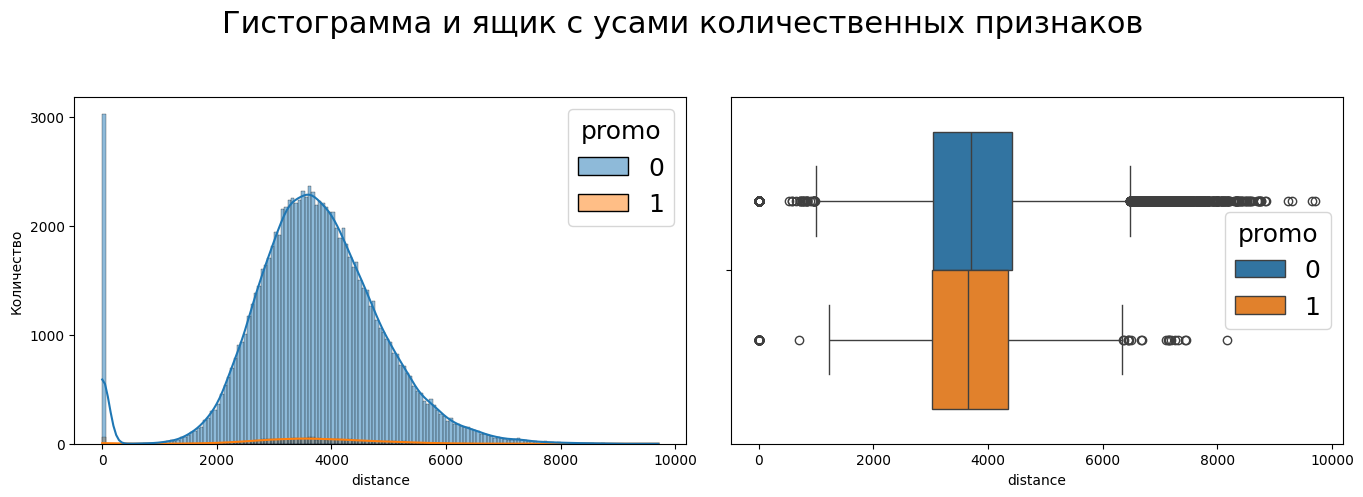

In [16]:
plot_hist_boxplot(data=rides_data, columns=["distance"], hue="promo", kde=True)

При первичном анализе можно заметить, что распределение дистанции поездок примерно нормальное,
с небольшой асимметрией в правую сторону (т.е. есть редкие длинные поездки, создающие длинный хвост).

## 7. Осмотр погодных данных

### 7.1. Первые строки и базовая очистка

In [17]:
weather_data.head(10)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,NaT,°C,mm,km/h,km/h,%,min
1,2023-04-01 00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01 02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01 03:00:00,8.690246,0.3,55.44,21.94524,77,0
5,2023-04-01 04:00:00,8.630245,0.3,48.96,22.42427,78,0
6,2023-04-01 05:00:00,8.430245,0.5,48.6,22.91026,77,0
7,2023-04-01 06:00:00,8.690246,0.3,50.039997,23.1774,98,0.5287884
8,2023-04-01 07:00:00,8.860246,0.4,52.56,23.166216,89,6.060605
9,2023-04-01 08:00:00,8.640245,0.5,63,20.371038,92,4.242425


При просмотре первых строк датасета можно заметить, что первая строка содержит единицы измерения для каждого столбца, а не реальные данные. Это указывает на то, что данная строка фактически является служебной и должна быть удалена или обработана как метаданные.

#### `weather_data` содержит следующую важную информацию о параметрах квартир:

* __datetime__ - время измерения
* __temperature__ - температура воздуха
* __precipitation_total__ - осадки
* __wind_speed__ - скорость ветра
* __wind_gust__ - порывы ветра (макс скорость)
* __cloud_cover_total__ - облачность (% покрытия)
* __sunshine_duration__ - Солнечное сияние (мин)

In [18]:
weather_data = weather_data.iloc[1:].reset_index(drop=True)
cat_cols = weather_data.select_dtypes(include=[object]).columns

for cat in cat_cols:
    weather_data[cat] = pd.to_numeric(weather_data[cat], errors="coerce")

После базовой очистки данные были приведены к корректным типам: все числовые столбцы преобразованы в формат `float` для дальнейшего анализа и визуализации.

### 7.2. Информация о данных

In [19]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   float64       
 2   precipitation_total  3642 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3656 non-null   float64       
 5   cloud_cover_total    3652 non-null   float64       
 6   sunshine_duration    3660 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


In [20]:
rows, cols = weather_data.shape
print(f"Кол-во строк: {rows}\nКол-во столбцов: {cols}")

Кол-во строк: 3672
Кол-во столбцов: 7


### 7.3. Пропуски и дубликаты

Проверим наличие пропусков в датасете:

In [21]:
get_missed_info(weather_data, rows, cols)


Проверка пропусков
Общее число пропусков: 133
Доля пропущенных ячеек: 0.5%
Доля строк с пропусками: 3.6%

Пропуски по столбцам:
datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64


Проверим последовательные блоки пропусков для ключевых погодных признаков:

In [22]:
cols_to_check = [
    'temperature', 'wind_speed',
    'sunshine_duration', 'cloud_cover_total', 'precipitation_total'
]

print_consecutive_nans(weather_data, cols_to_check)

temperature: 6 блоков пропусков, максимальная длина 23 строк
Длины всех блоков: [10, 8, 3, 6, 5, 23]
wind_speed: 4 блоков пропусков, максимальная длина 5 строк
Длины всех блоков: [4, 5, 3, 4]
sunshine_duration: 3 блоков пропусков, максимальная длина 5 строк
Длины всех блоков: [5, 3, 4]
cloud_cover_total: 4 блоков пропусков, максимальная длина 8 строк
Длины всех блоков: [6, 8, 3, 3]
precipitation_total: 4 блоков пропусков, максимальная длина 14 строк
Длины всех блоков: [3, 9, 4, 14]


**Вывод по пропускам:**
* Пропуски встречаются нечасто (0,5% всех ячеек) и в большинстве случаев небольшими блоками.
* На основании анализа последовательных пропусков можно заключить, что применение интерполяции по времени (method='time') корректно для большинства признаков.
* Особое внимание стоит уделить блокам температуры, где встречаются более длинные пропуски (до 23 строк). Для этих случаев, а также для пропусков солнечного сияния и осадков, рекомендуется заполнять значения медианой для сохранения корректного паттерна данных.


Проверим наличие дубликатов в датасете:

In [23]:
get_duplicated_info(weather_data)


Проверка на дубликаты
Кол-ва дубликатов: 0


Анализ дубликатов показал, что в датасете нет повторяющихся строк.
Это означает, что данные уникальны и не требуют дополнительной очистки от дубликатов.

### 7.4. Описательные статистики

In [24]:
weather_data.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,3672,2023-06-16 11:30:00.000000256,2023-04-01 00:00:00,2023-05-09 05:45:00,2023-06-16 11:30:00,2023-07-24 17:15:00,2023-08-31 23:00:00,NaN
temperature,3617.0,18.137779,-2.079755,13.270246,18.100245,23.010244,36.150246,6.848331
precipitation_total,3642.0,0.101043,0.0,0.0,0.0,0.0,5.8,0.34367
wind_gust,3672.0,20.886568,2.88,13.32,18.359999,26.28,71.28,10.436531
wind_speed,3656.0,7.345096,0.0,4.334974,6.28713,9.449572,29.96662,4.265649
cloud_cover_total,3652.0,41.056216,0.0,15.000001,33.0,67.0,100.0,31.318514
sunshine_duration,3660.0,21.50241,0.0,0.0,14.919949,42.454547,60.0,21.896528


Анализ описательных статистик погодных данных показывает следующее:

* Температура варьируется от –2,1 °C до 36,2 °C, среднее значение составляет около 18 °C. Диапазон соответствует весенне-летнему периоду, а умеренное стандартное отклонение отражает естественные колебания температуры.
* Осадки в большинстве наблюдений отсутствуют: медиана равна 0, а среднее значение — 0,10 мм. Максимальные значения достигают 5,8 мм, что соответствует умеренным дождям.
* Порывы ветра достигают 71,3 м/с, тогда как среднее значение удерживается на уровне около 20,9 м/с.
* Скорость ветра в среднем составляет 7,3 м/с, с максимумом почти 30 м/с — это указывает на периоды усиленного ветра в выборке.
* Облачность (cloud_cover_total) колеблется от 0 до 100 %, средний уровень — около 41 %, что отражает широкий спектр погодных состояний.
* Солнечное сияние (sunshine_duration) изменяется от 0 до 60 минут, среднее значение — примерно 21,5 минуты, что указывает на чередование пасмурных и солнечных периодов.

## 8. Визуализация распределений погодных параметров

Строим гистограммы и boxplot для всех числовых признаков:

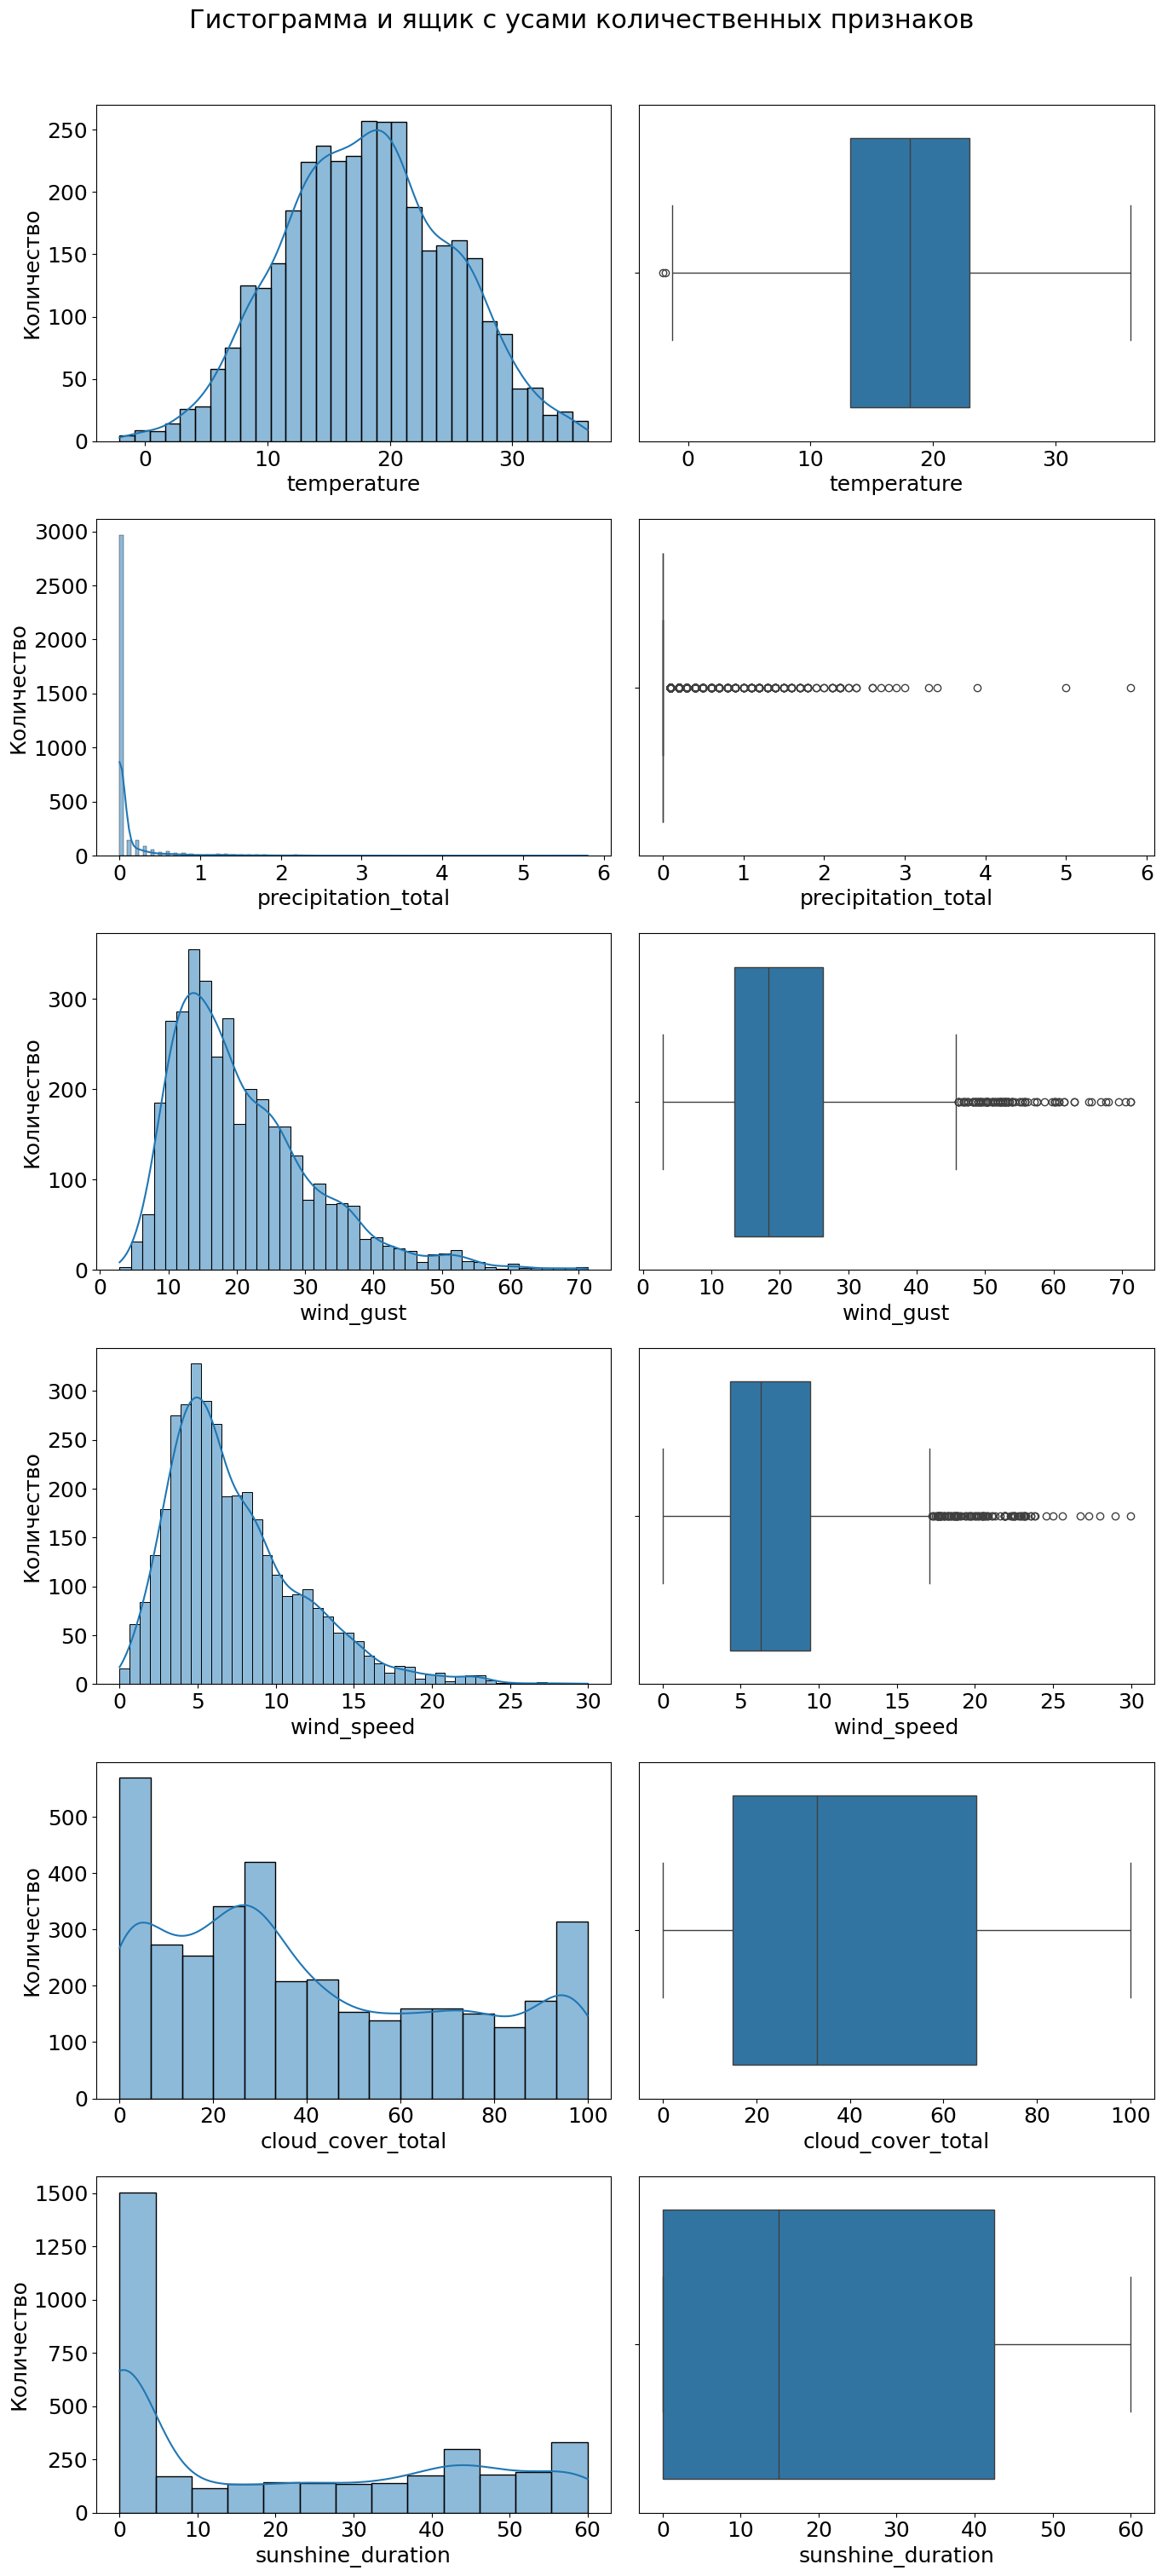

In [25]:
num_cols = weather_data.select_dtypes(include=["int", "float"]).columns

plot_hist_boxplot(data=weather_data, columns=num_cols, kde=True)

Первичный анализ метеорологических параметров показал следующие ключевые наблюдения:

* **Температура (`temperature`)**: близка к нормальному распределению с центром около 20°C, небольшая правосторонняя асимметрия.
* **Осадки (`precipitation_total`)**: сильно скошено вправо, большинство значений около нуля; редкие выбросы соответствуют интенсивным осадкам.
* **Ветер (`wind_gust` и `wind_speed`)**: скошены вправо, основная масса в низком диапазоне, редкие сильные порывы подтверждаются боксплотами.
* **Облачность (`cloud_cover_total`)**: распределение с несколькими пиками, часто встречаются крайние значения около 0% и 100%, а также пик около 25–30%. Преобладают либо полностью ясные, либо полностью облачные дни.
* **Солнечное сияние (`sunshine_duration`)**: дискретное поле в минутах. Большинство наблюдений около нуля, длинный правый хвост до 60 минут отражает редкие ясные дни.

## 9. Оценка корреляций схожих признаков

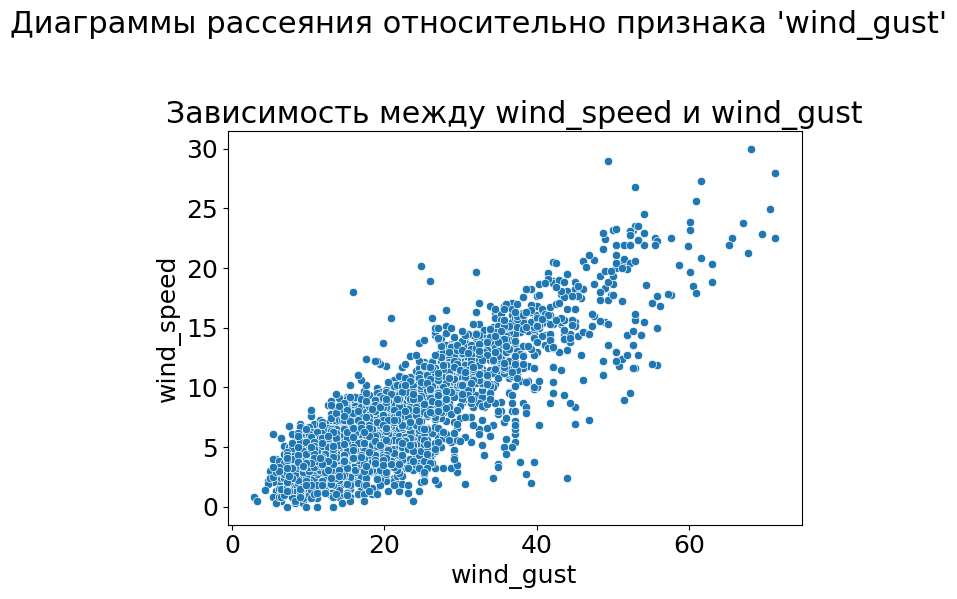

In [26]:
plot_scatterplot(weather_data, "wind_gust", ["wind_speed"], ncols=1)

На диаграмме рассеяния хорошо прослеживается сильная положительная корреляция между признаками wind_speed и wind_gust. Это говорит о том, что факторы содержат схожую информацию. В таких случаях один из признаков может быть избыточным — например, wind_gust можно удалить.

## 10. Проверяем корректность промокода
Находим поездки, в которых значение `promo = 1`, но время начала не попадает в окно акции (06:00–09:59).

In [27]:
# Условия корректного промо
correct_promo = rides_data["start_date"].dt.hour.between(6, 9)

# Ошибки:
# promo == "Да", но время НЕ из диапазона
wrong_yes = (rides_data["promo"] == 1) & (~correct_promo)


print("Неверно помеченные промо (Да вне времени):", wrong_yes.sum())

Неверно помеченные промо (Да вне времени): 0


## Вывод по первичному анализу данных поездок и погоды

На основе первичного анализа можно выделить ключевые наблюдения и рекомендации для последующей предобработки данных.

### 1. Данные о поездках
- **Пропуски**: Их количество невелико (≈0,2% всех ячеек), сосредоточены в столбцах `end_date` и `distance`. Пропущенные значения можно безопасно восстановить медианой или удалить строки без значительной потери информации.
- **Дубликаты**: Обнаружено ~4,8% дубликатов. Для корректной статистики и визуализации их следует удалить.
- **Выбросы по дистанции**: Минимальные и максимальные значения расстояния явно выходят за разумные пределы (1 м и >7 500 км). Требуется фильтрация или удаление этих аномальных значений.
- **Категориальные признаки**: Некоторые районы и локации дублируются с различиями в регистре и дефисах. Необходимо нормализовать текстовые значения.
- **Дополнительные признаки**: Поле `promo` следует привести к бинарному категориальному признаку для удобства анализа.

### 2. Данные о погоде
- **Пропуски**: Общий уровень пропусков умеренный (0,5% ячеек). Последовательные блоки пропусков для некоторых признаков (например, `temperature`) могут достигать до 23 строк. Для небольших блоков можно безопасно применять интерполяцию по времени (`method='time'`).
  Для длинных блоков, а также для признаков `temperature` и `sunshine_duration`, рекомендуется рассматривать заполнение медианой или проверять корректность интерполяции относительно физического паттерна данных (например, солнечное сияние ночью).
- **Дубликаты**: Отсутствуют — данные уникальны.
- **Экстремальные значения и распределения**: Признаки имеют разумный диапазон, экстремальные значения встречаются редко и могут быть проверены визуально.

### 3. Взаимосвязи и корреляции
- Сильная корреляция между `wind_speed` и `wind_gust` указывает на возможное дублирование информации. Один из признаков можно удалить или оставить по необходимости.
- Другие признаки не демонстрируют критических противоречий, что позволяет применять стандартные методы очистки и нормализации.

### 4. Рекомендации для предобработки
На основании анализа следующие шаги являются обоснованными:

1. **Удаление дубликатов** в данных о поездках.
2. **Фильтрация или корректировка выбросов** по дистанции поездок.
3. **Нормализация категориальных признаков** (локации и районы) для единообразия.
4. **Обработка пропусков**:
   - В данных о поездках — восстановление медианой маршрутов или удаление строк.
   - В погодных данных — интерполяция по времени для небольших блоков пропусков и проверка корректности для длинных блоков. Для температуры, солнечного сияния и осадков можно использовать медиану при необходимости.
5. **Создание дополнительных признаков**: длительность поездки, средняя скорость, день недели и др.
6. **Приведение типов и категориальных значений** к корректным форматам для анализа и моделирования.

**Вывод:**
Данные достаточно качественные для начала предобработки. Основное внимание следует уделить дубликатам, выбросам, блокам пропусков и нормализации текстовых признаков. Применение интерполяции по времени возможно, но требует осторожности на длинных пропущенных сегментах.